In [1]:
import sys
import os

import os
os.makedirs("C:/temp/spark", exist_ok=True)
os.environ["PYSPARK_PYTHON"] = r"C:\Users\jakub\AppData\Local\Programs\Python\Python310\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\jakub\AppData\Local\Programs\Python\Python310\python.exe"
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from pyspark.sql import SparkSession
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, OneVsRest, NaiveBayes, RandomForestClassifier
from preprocessing.preprocessing import preprocess_data
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# Vytvorenie SparkSession
spark = SparkSession.builder \
    .appName("Modelling_1") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .master("local[*]") \
    .getOrCreate()

# Nastavenie úrovne logovania
spark.sparkContext.setLogLevel("ERROR")


In [2]:
df_train, df_test = preprocess_data()
df_train.select("features", "Accident_Severity").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------+-----------------+
|features                                                                                                      |Accident_Severity|
+--------------------------------------------------------------------------------------------------------------+-----------------+
|[525590.0,178860.0,1.0,3.0,1.0,12.0,4.0,30.0,3.0,2.0,5.0,0.0,1.0,1.0,1.0,1.0,3.0,5.0,6.0,8.0,0.0,1.0,8.0]     |3                |
|[524940.0,178540.0,1.0,2.0,1.0,12.0,4.0,40.0,0.0,-1.0,-1.0,0.0,1.0,1.0,1.0,1.0,3.0,3.0,12.0,0.0,0.0,1.0,8.0]  |3                |
|[527870.0,178350.0,1.0,1.0,1.0,12.0,0.0,30.0,3.0,4.0,6.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,16.0,1.0,0.0,4.0,7.0]    |2                |
|[527200.0,178760.0,1.0,3.0,1.0,12.0,308.0,30.0,3.0,2.0,5.0,0.0,1.0,1.0,1.0,1.0,3.0,2.0,16.0,1.0,0.0,1.0,14.0] |3                |
|[525200.0,179360.0,1.0,2.0,1.0,12.0,315.0,30.0,0.0,-1.0,-1.0,0.0,1.0,1.0,2.0,1.0,3

In [3]:
if 'label' in df_train.columns:
    df_train = df_train.drop('label')
if 'label' in df_test.columns:
    df_test = df_test.drop('label')

labelIndexer = StringIndexer(inputCol="Accident_Severity", outputCol="label")
fitted_indexer = labelIndexer.fit(df_train)
df_train = fitted_indexer.transform(df_train)
df_test = fitted_indexer.transform(df_test)

In [4]:
def evaluate_model(model, data, model_name):
    predictions = model.transform(data)

    predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))

    metrics = MulticlassMetrics(predictionAndLabels)

    labels = [float(l) for l in metrics._java_model.labels()]
    confusion_matrix = metrics.confusionMatrix().toArray()

    print(f"\n--- {model_name} Confusion Matrix ---")

    header = "True \\ Predicted"
    for l in labels:
        header += f"\t{int(l)}"
    print(header)

    for i, l in enumerate(labels):
        row = f"{int(l)}"
        for j in range(len(labels)):
            row += f"\t{int(confusion_matrix[i][j])}"
        print(row)

    precisions = [metrics.precision(label) for label in labels]
    recalls = [metrics.recall(label) for label in labels]
    f1Scores = [metrics.fMeasure(label) for label in labels]

    precision = sum(precisions) / len(precisions)
    recall = sum(recalls) / len(recalls)
    f1Score = sum(f1Scores) / len(f1Scores)

    n_classes = len(labels)
    confusion_sum = confusion_matrix.sum()

    cov_xy = 0
    cov_xx = 0
    cov_yy = 0

    for i in range(n_classes):
        row_sum = sum(confusion_matrix[i])
        col_sum = sum(confusion_matrix[:, i])

        cov_xy += row_sum * col_sum
        cov_xx += row_sum * row_sum
        cov_yy += col_sum * col_sum

    mcc_numerator = 0
    for i in range(n_classes):
        for j in range(n_classes):
            mcc_numerator += confusion_matrix[i][j] * (confusion_matrix.sum() * confusion_matrix[i][j] -
                                                     sum(confusion_matrix[i]) * sum(confusion_matrix[:, j]))

    mcc_denominator = np.sqrt((confusion_sum**2 - cov_xx) * (confusion_sum**2 - cov_yy))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

    print(f"\n--- {model_name} Evaluation Metrics ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1Score:.4f}")
    print(f"MCC: {mcc:.4f}\n")

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1Score,
        "mcc": mcc,
        "confusion_matrix": confusion_matrix
    }

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)
dt_model = dt.fit(df_train)
dt_metrics = evaluate_model(dt_model, df_test, "Decision Tree")

base_classifier = LinearSVC(maxIter=10, regParam=0.1, featuresCol="features")
lsvc = OneVsRest(classifier=base_classifier, labelCol="label")
lsvc_model = lsvc.fit(df_train)
lsvc_metrics = evaluate_model(lsvc_model, df_test, "Linear SVM")

>> [1/6] Trénujem Decision Tree...
>> [2/6] Vyhodnocujem Decision Tree...


c:\Users\jakub\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



--- Decision Tree Confusion Matrix ---
True \ Predicted	0	1	2
0	107855	0	0
1	5188	12764	0
2	783	418	1307

--- Decision Tree Evaluation Metrics ---
Precision: 0.9719
Recall: 0.7440
F1 Score: 0.8261
MCC: 46296.1206

>> [3/6] Hotovo - Decision Tree.
>> [4/6] Trénujem Linear SVM (One-vs-Rest)...
>> [5/6] Vyhodnocujem Linear SVM...

--- Linear SVM Confusion Matrix ---
True \ Predicted	0	1	2
0	107855	0	0
1	5334	12618	0
2	826	1682	0

--- Linear SVM Evaluation Metrics ---
Precision: 0.6094
Recall: 0.5676
F1 Score: 0.5849
MCC: 46038.6557

>> [6/6] Hotovo - Linear SVM.


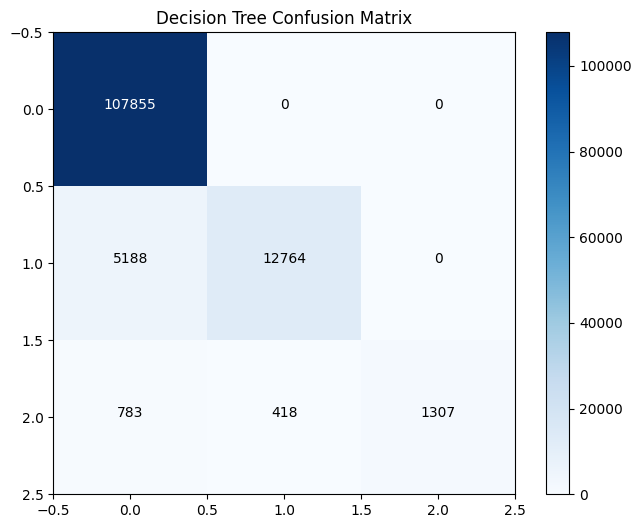

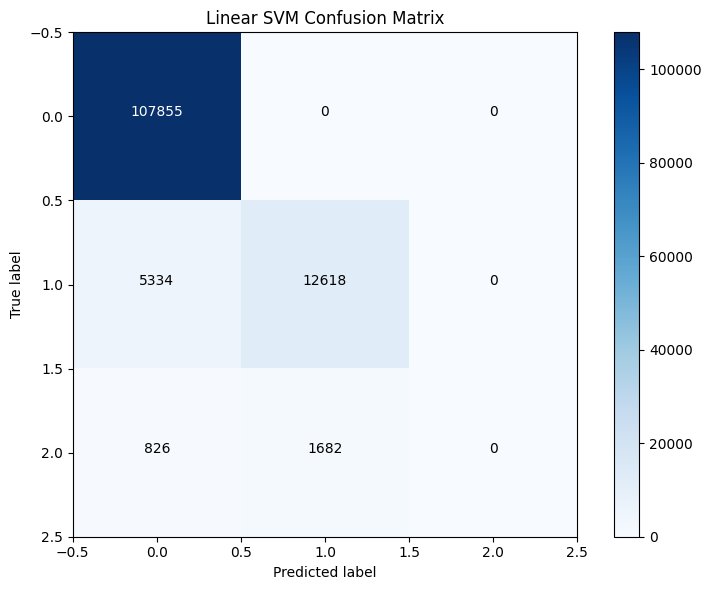

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(dt_metrics["confusion_matrix"], interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.colorbar()

thresh = dt_metrics["confusion_matrix"].max() / 2
for i in range(dt_metrics["confusion_matrix"].shape[0]):
    for j in range(dt_metrics["confusion_matrix"].shape[1]):
        plt.text(j, i, format(int(dt_metrics["confusion_matrix"][i, j]), 'd'),
                horizontalalignment="center",
                color="white" if dt_metrics["confusion_matrix"][i, j] > thresh else "black")

plt.figure(figsize=(8, 6))
plt.imshow(lsvc_metrics["confusion_matrix"], interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Linear SVM Confusion Matrix")
plt.colorbar()

# Add numbers to the cells
thresh = lsvc_metrics["confusion_matrix"].max() / 2
for i in range(lsvc_metrics["confusion_matrix"].shape[0]):
    for j in range(lsvc_metrics["confusion_matrix"].shape[1]):
        plt.text(j, i, format(int(lsvc_metrics["confusion_matrix"][i, j]), 'd'),
                horizontalalignment="center",
                color="white" if lsvc_metrics["confusion_matrix"][i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [9]:
# --- Zistenie minimálnej hodnoty vo features ---
min_feature_value = df_train.select("features").rdd.map(lambda row: float(min(row["features"]))).min()
print(f">>> Minimálna hodnota vo features: {min_feature_value}")

# --- Posun, ak sú hodnoty záporné ---
if min_feature_value < 0:
    shift_value = abs(min_feature_value) + 1.0
    print(f">>> Posúvam všetky hodnoty o: {shift_value}")

    def shift_vector(vec):
        return Vectors.dense([x + shift_value for x in vec])

    shift_udf = udf(shift_vector, VectorUDT())

    df_train = df_train.withColumn("features", shift_udf("features"))
    df_test = df_test.withColumn("features", shift_udf("features"))
    print(">>> Shift hotový.")
else:
    print(">>> Všetky hodnoty sú nezáporné, shift netreba.")

# --- Trénovanie Naive Bayes ---
nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0, modelType="multinomial")
nb_model = nb.fit(df_train)
print(">>> Naive Bayes model natrenovaný.")

# --- Vyhodnotenie ---
nb_metrics = evaluate_model(nb_model, df_test, "Naive Bayes")


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 864.0 failed 1 times, most recent failure: Lost task 2.0 in stage 864.0 (TID 19988) (LAPTOP-J0DGCL8C executor driver): java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.flushBuffer(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:308)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:320)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:320)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:320)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:57)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:440)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:274)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.flushBuffer(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:308)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:320)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:320)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:320)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:57)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:440)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:274)


In [8]:
# Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=5)
rf_model = rf.fit(df_train)
rf_metrics = evaluate_model(rf_model, df_test, "Random Forest")

plt.figure(figsize=(8, 6))
plt.imshow(rf_metrics["confusion_matrix"], interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.colorbar()
thresh = rf_metrics["confusion_matrix"].max() / 2
for i in range(rf_metrics["confusion_matrix"].shape[0]):
    for j in range(rf_metrics["confusion_matrix"].shape[1]):
        plt.text(j, i, format(int(rf_metrics["confusion_matrix"][i, j]), 'd'),
                 horizontalalignment="center",
                 color="white" if rf_metrics["confusion_matrix"][i, j] > thresh else "black")

Py4JJavaError: An error occurred while calling o2317.labels.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 852.0 failed 1 times, most recent failure: Lost task 7.0 in stage 852.0 (TID 19951) (LAPTOP-J0DGCL8C executor driver): java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.flushBuffer(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:308)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:320)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:320)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:320)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:57)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:440)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:274)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:78)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labels$lzycompute(MulticlassMetrics.scala:241)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labels(MulticlassMetrics.scala:241)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.flushBuffer(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:308)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:320)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:320)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:320)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:57)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:440)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:274)
